In [2]:
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from io import StringIO # Python3 use: from io import StringIO
import sys
from utils.wrapper import *
from abc import ABC, abstractmethod
#from utils.diagnostics import *
%matplotlib notebook
np.set_printoptions(formatter={'float': lambda x: "{0:5.3f}".format(x)})

to do : 
    1. test more functions
    3. plot grid of convergence
    4. try gradient descent-Adam on some function
    5. test property A and B
    
    ** refactor the code of library

In [2]:
def draw_ellipse(self, ax, mean, var_half):
    eigVal_sqrt = np.linalg.norm(var_half, ord=2, axis=(0))
    eigVec = var_half / eigVal_sqrt
    width, height = 2 * 3 * eigVal_sqrt
    angle = np.arctan2(eigVec[0,1], eigVec[0,0]) * 180 / np.pi
    e1 = patches.Ellipse(mean, width, height,
                         angle=-angle, linewidth=2, fill=False, zorder=2)
    ax.add_patch(e1)
    ax.scatter(mean[0], mean[1], c='black', s=15)
    
def setup_scatter(self, ax, i):
    '''
    set up the plot of CMA-ES candidates at i-th iteration
    '''
    # draw x-axis and y-axis
    ax.axvline(c='grey', lw=1)
    ax.axhline(c='grey', lw=1)
    # draw the position of optimal 
    ax.scatter(self.optimal[0], self.optimal[1], c='red', s=15)
    # draw the trail of local minimum
    if self.trail:
        ax.scatter(self.trail[0], self.trail[1], c='red', s=11)
    # draw candidates on scatter plot
    ax.set_xlim(np.min(self.arg[:,:,0]), np.max(self.arg[:,:,0]))
    ax.set_ylim(np.min(self.arg[:,:,1]), np.max(self.arg[:,:,1]))
    p = sns.scatterplot(x=self.arg[i,:,0], y=self.arg[i,:,1], color="r", hue=i, hue_norm=(0, self.val.shape[0]), legend=False)
    # draw ellipse representing 3 sigma areas of normal distribution
    self.draw_ellipse(ax, self.stats['mean'][i], self.stats['var'][i])
    
def animate_moving_cluster(self):
    def animate(i):
        plt.clf()
        ax = fig.add_subplot(1, 1, 1)    
        ax.set_title('iter=%d' % (i+1))
        self.setup_scatter(ax, i+1)
    fig = plt.figure(figsize=(8,4))
    ani = animation.FuncAnimation(fig, animate, frames=self.arg.shape[0]-1, repeat=False, interval=500)
    return ani

def animate_scatterplot_distance(self):
    def animate(i):
        plt.clf()
        # draw scatter and ellipse
        ax0 = fig.add_subplot(2, 1, 1)
        ax0.set_title('iter=%d, func_dist=%.1f,  arg_distance=%.1f, mean=(%.3f, %.3f)' % (i+1, self.distance_val[i+1], self.distance_arg[i+1], \
                                    self.stats['mean'][i+1,0], self.stats['mean'][i+1,1]))
        self.setup_scatter(ax0, i+1)
        # plot distance
        ax1 = fig.add_subplot(2, 1, 2)
        self.plot_distance_common(ax1, i)
    self.get_distance()
    fig = plt.figure(figsize=(8,4))
    ani = animation.FuncAnimation(fig, animate, frames=self.val.shape[0]-1, repeat=False, interval=500)
    return ani

non_convex_optimisation.animate_moving_cluster = animate_moving_cluster
non_convex_optimisation.animate_scatterplot_distance = animate_scatterplot_distance
non_convex_optimisation.setup_scatter = setup_scatter
non_convex_optimisation.draw_ellipse = draw_ellipse

# tested objective function

In [10]:
class bukin(objective_func):
    '''
    non-disappearing gradient
    large gradient and uncontinuous gradient around ridge/local optimal
    optimum: 0
    optimal: (-10, 1)
    '''
    def func(x):
        return 100 * np.sqrt(np.abs(x[1] - 0.01 * x[0]**2)) + 0.01 * np.abs(x[0] + 10)
    def dfunc(x):
        arg1 = x[1] - 0.01 * x[0]**2
        arg2 = 1 / np.sqrt(np.abs(arg1)) if arg1 != 0 else 0
        return np.array([- np.sign(arg1) * x[1] * arg2 + 0.01 * np.sign(x[0] + 10), 50 * np.sign(arg1) * arg2])
    def get_optimal():
        return np.array([-10, 1])
    def get_optimum():
        return 0
    def local_optimal_trail(x1):
        return 0.01 * x1**2
    def bukin_first(x):
        return 100 * np.sqrt(np.abs(x[1] - 0.01 * x[0]**2))
    def bukin_second(x):
        return 0.01 * np.abs(x[0] + 10)
    def bukin_second_strong(x):
        return 100 * np.sqrt(np.abs(x[1] - 0.01 * x[0]**2)) + 100 * np.abs(x[0] + 10)



# Visualisation tool

In [4]:
def plot_scatter(func, lim, N):
    x, y = np.linspace(-lim, lim, N), np.linspace(-lim, lim, N)
    xx, yy = np.meshgrid(x, y)
    zz = np.zeros(xx.shape)
    for i in range(len(x)):
        for j in range(len(y)):
            zz[i, j] = func([x[i], y[j]])
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.scatter(x=xx.ravel(), y=yy.ravel(),c=zz.ravel())
    fig.show()
    
def plot_surface(func, lim, N):
    x, y = np.linspace(-lim, lim, N), np.linspace(-lim, lim, N)
    z = []
    for i in x:
        z_line = []
        for j in y:
            z_line.append(func([i,j]))
        z.append(z_line)

    fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
    fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                      highlightcolor="limegreen", project_z=True))
    fig.update_layout(autosize=False,
                      scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                      width=500, height=500,
                      margin=dict(l=65, r=50, b=65, t=90)
    )
    fig.show()

<IPython.core.display.Javascript object>


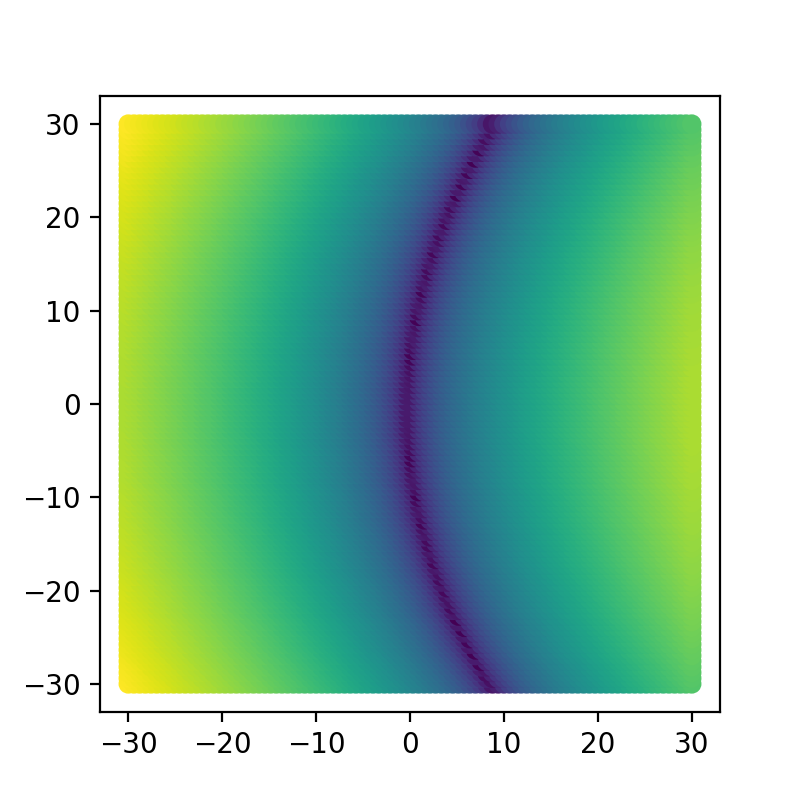

In [5]:
N = 100
lim = 30
plot_scatter(bukin, lim, N)

In [7]:
plot_surface(bukin, lim, N)

## first part of bukin

In [8]:
plot_surface(bukin_first, lim, N)

## second part of bukin

In [9]:
plot_surface(bukin_second, lim, N)

In [35]:
import importlib
import utils.wrapper as nco
import utils.computation as comp
importlib.reload(nco)
importlib.reload(comp)

<module 'utils.computation' from '/Users/huajian/Non-convex/utils/computation.py'>

# numerical experiments

### ridge where local minimas distributed 

In [6]:
x = np.linspace(-50, 50, 201)

y = parabola(x)
ridge = (x, y)

In [25]:
class single_experiment:
    def set_objective_func(objective_func):
        self.objective_func = objective_func

    def set_optimisation_method(optimizer):
        self.optimizer = optimizer

    def do_experiment():
        optimal, optimum, statistics = self.optimizer.optimise(self.objective_func)
        if np.linalg.norm(optimal - self.objective_func.get_optimal) < 1e-1 \
        or np.linalg.norm(optimum - self.objective_func.get_optimum) < 1e-1:
            statistics['status'] = 'global minimum'
        elif statistics['status'] != 'diverge':
            statistics['status'] = 'local minimum'
        print(statistics['status'])
        self.analyser = post_analysis(statistics)
        

In [ ]:
class multiple_experiments():
    def set_size():
        self.size = size
    def do_experiment():
        nco = NCO()
        objective = ...
        nco.set_objective_func(objective)
        optimizer = ...
        for i, point in enumerate(self.points())
            paras['mean0'] =  
            optimizer.set_parameters(paras)
            nco.set_optimisation_method(optimizer)
            stats = noc.do_experiment()
            batch.append(stats)
            if i % self.size == 0:
                analyse(batch, point)
                batch = []
                
    def analyse(batch, point):
        x1, x2 = int(point[0]), int(point[1])
        interest = np.zeros((self.size,))
        for i in range(self.size):
            interest[i] = batch[i]['']
        self.report[x1, x2] = interest.mean()
            

3

## original CMA

- initial mean $$ \left( \begin{array}{cc} -21.9 & 10 \end{array}\right) $$
- initial variance
$$ \left( \begin{array}{cc} 0.003^2 & 0 \\ 0 & 0.003^2 \end{array}\right) $$

In [8]:
mean0 = np.array([[-21.9],[10]])
sigma = np.ones((2,)) * 0.003
alpha = 1
beta = 2
np.random.seed(101)
optimal = np.array([-10,1])
optimum = 0
tolerance = 1 * 1e-3

ex1 = non_convex_optimisation()
ex1.do_experiments(mean0, sigma, alpha, beta, do_nothing, tolerance)

NameError: name 'd_bukin' is not defined

In [27]:
bukin((0,0))

0.1

In [29]:
bukin(ridge)

array([0.400, 0.395, 0.390, 0.385, 0.380, 0.375, 0.370, 0.365, 0.360,
       0.355, 0.350, 0.345, 0.340, 0.335, 0.330, 0.325, 0.320, 0.315,
       0.310, 0.305, 0.300, 0.295, 0.290, 0.285, 0.280, 0.275, 0.270,
       0.265, 0.260, 0.255, 0.250, 0.245, 0.240, 0.235, 0.230, 0.225,
       0.220, 0.215, 0.210, 0.205, 0.200, 0.195, 0.190, 0.185, 0.180,
       0.175, 0.170, 0.165, 0.160, 0.155, 0.150, 0.145, 0.140, 0.135,
       0.130, 0.125, 0.120, 0.115, 0.110, 0.105, 0.100, 0.095, 0.090,
       0.085, 0.080, 0.075, 0.070, 0.065, 0.060, 0.055, 0.050, 0.045,
       0.040, 0.035, 0.030, 0.025, 0.020, 0.015, 0.010, 0.005, 0.000,
       0.005, 0.010, 0.015, 0.020, 0.025, 0.030, 0.035, 0.040, 0.045,
       0.050, 0.055, 0.060, 0.065, 0.070, 0.075, 0.080, 0.085, 0.090,
       0.095, 0.100, 0.105, 0.110, 0.115, 0.120, 0.125, 0.130, 0.135,
       0.140, 0.145, 0.150, 0.155, 0.160, 0.165, 0.170, 0.175, 0.180,
       0.185, 0.190, 0.195, 0.200, 0.205, 0.210, 0.215, 0.220, 0.225,
       0.230, 0.235,

In [11]:
val, arg, stats = ex1.get_recorded_data()

<IPython.core.display.Javascript object>


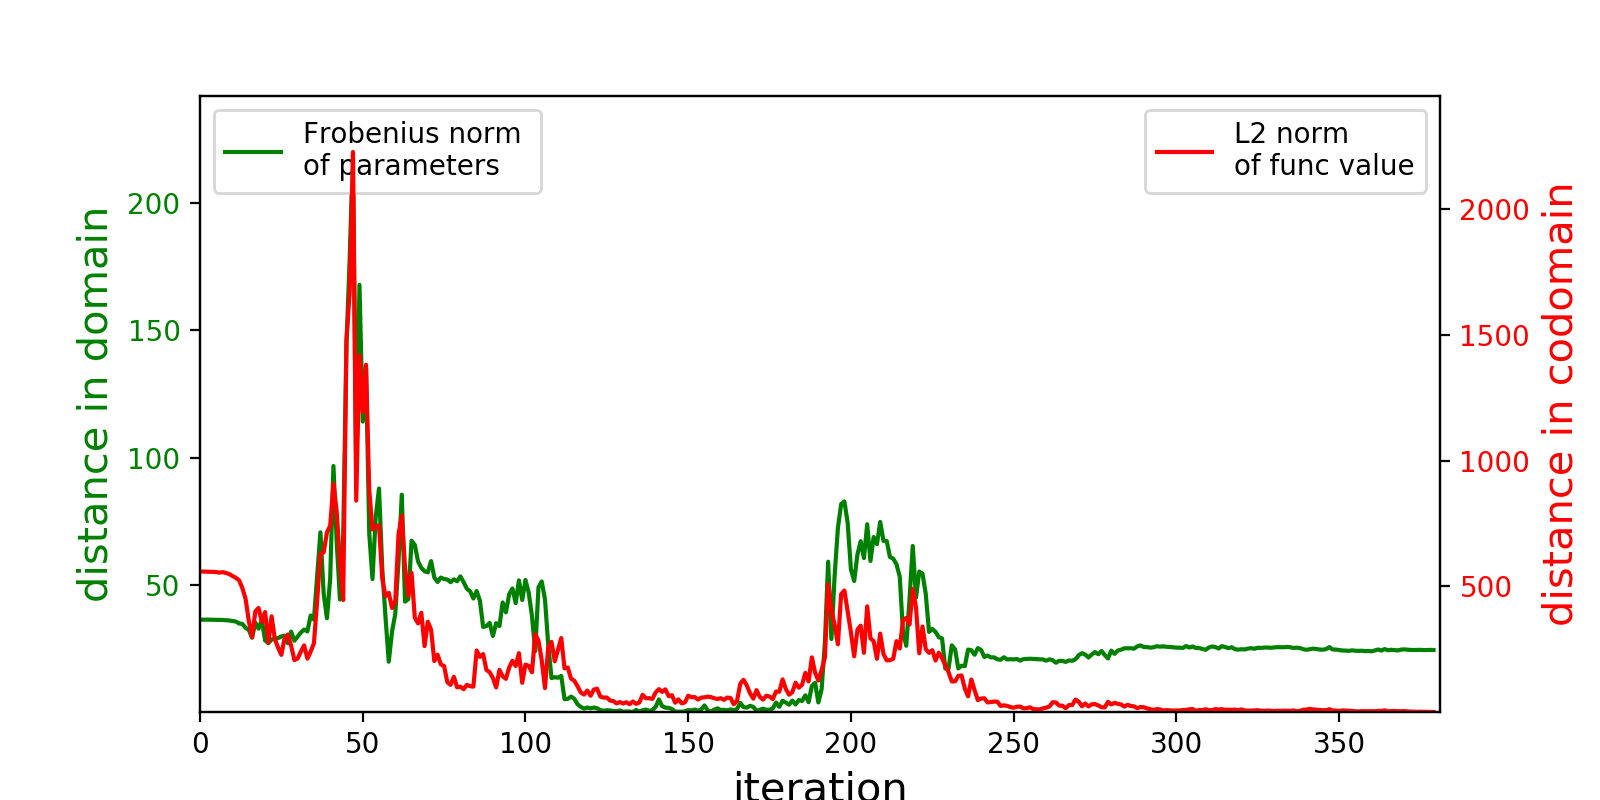

In [26]:
ex1.plot_distance()

<IPython.core.display.Javascript object>


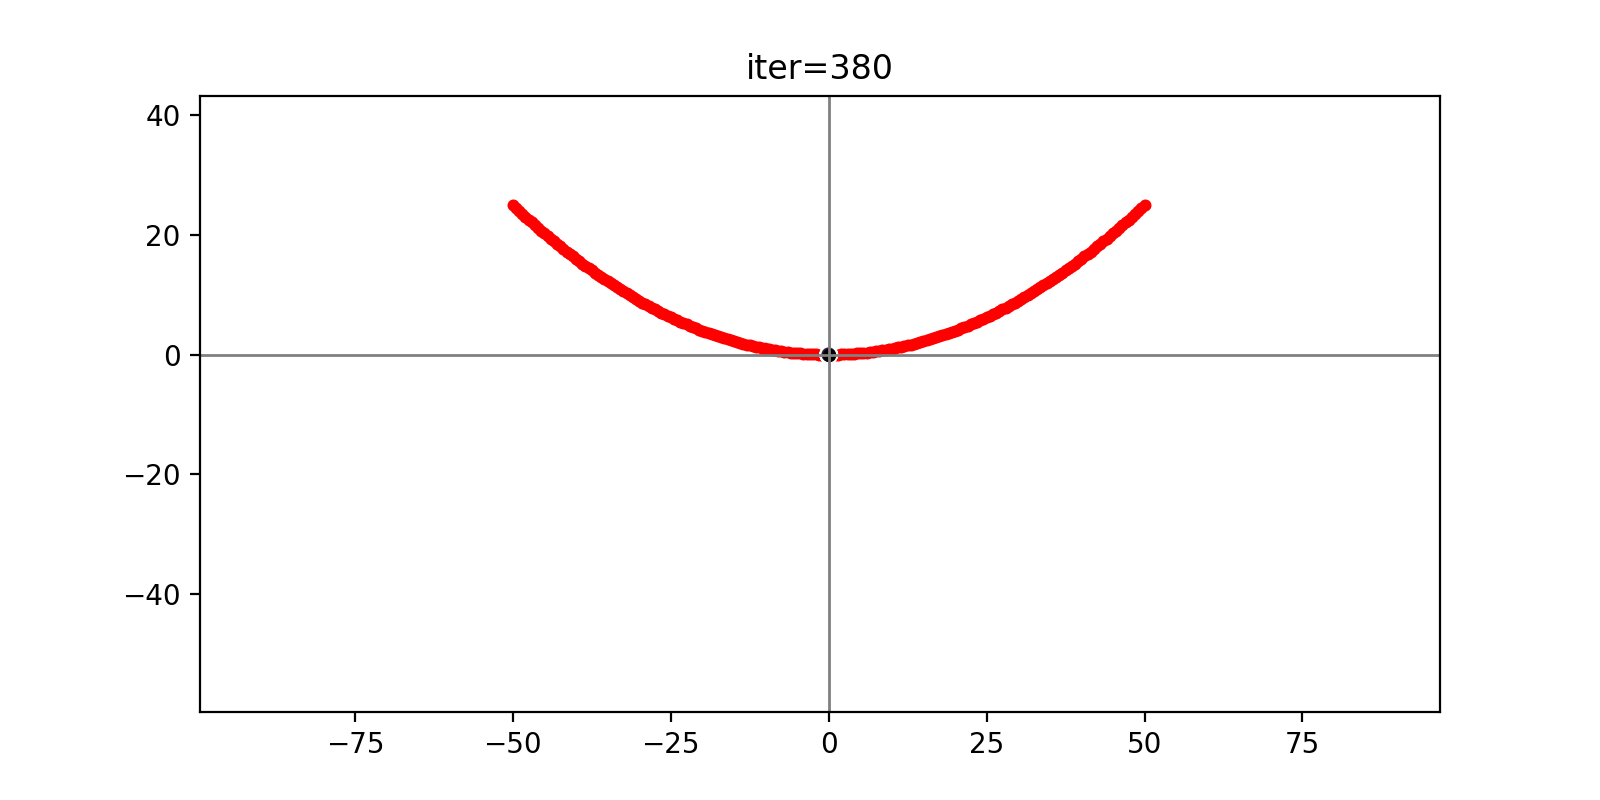

In [22]:
ex1.animate_moving_cluster()

<IPython.core.display.Javascript object>


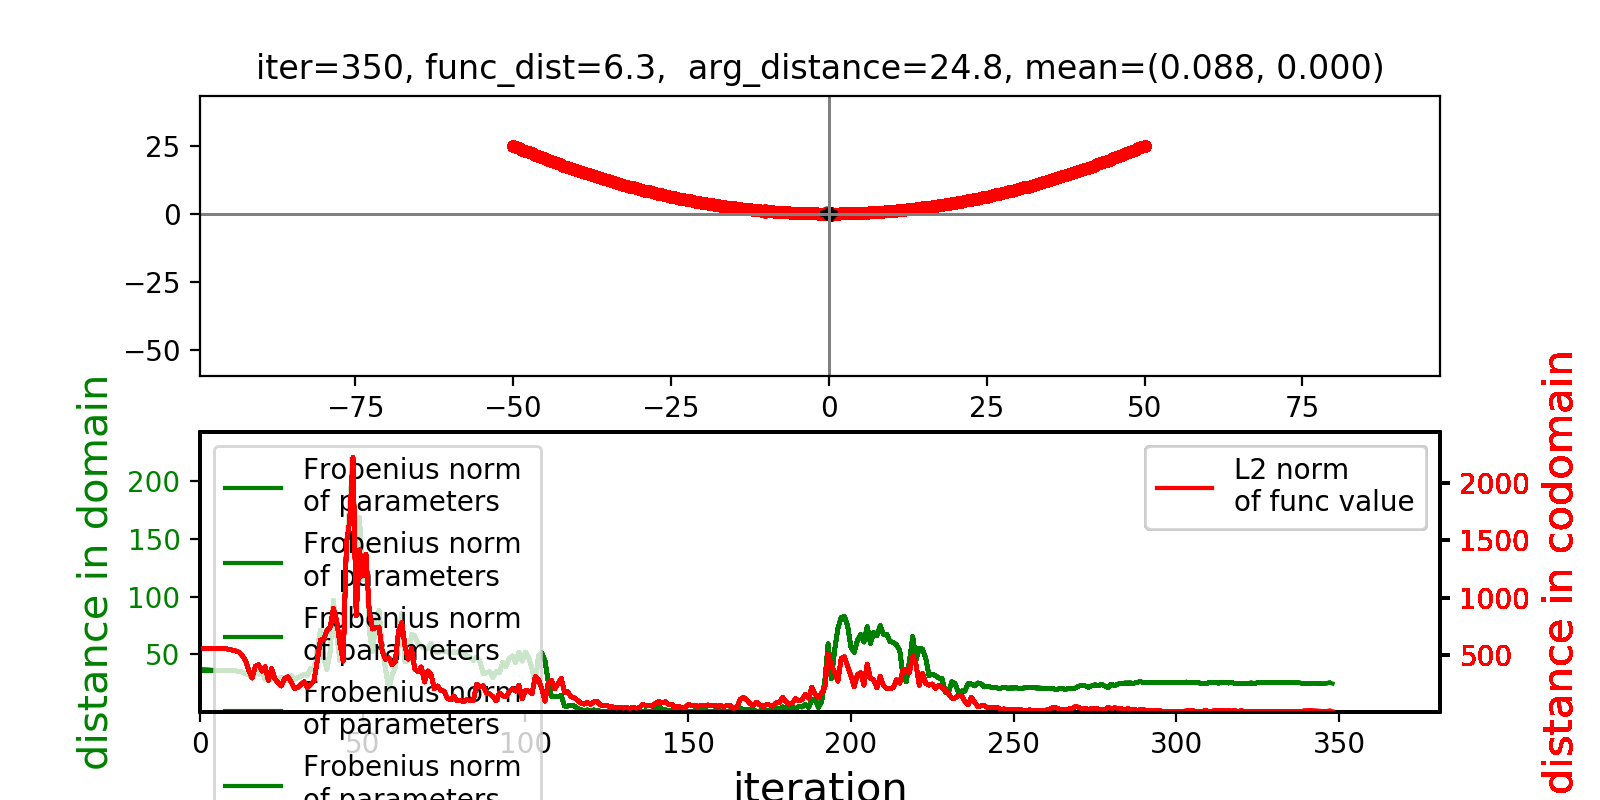

In [17]:
ani = ex1.animate_scatterplot_distance()

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)
ani.save('ex1_originalCMA_Bukin.mp4', writer=writer)

### remark:
- distance in domain is smaller than that in codomain, but residual distance is harder to reduce, minima often stucks at (0 , 0) 
- difficulies are caused by large and volatile gradient, this is contrary to Ackley, whose difficulties are caused by disappearing gradient
- specifically, detecting the slight difference of gradient along ridge direction is difficult when gradient across ridge is large. 
- Similarity as Ackley: slight, useful, low frequency global information is immersed in local, frequent changed  local information. But local information is not pure noise, it also guide to global optimal.

## line search multple step

### much smaller line search hyper-parameters:
 $$\alpha = 10^{-5}$$
 $$\beta = 2*10^{-5}$$

In [24]:
mean0 = np.array([[-21.9],[10]])
sigma = np.ones((2,)) * 0.003
alpha = 0.00001
beta = 0.00002
tolerance = 1 * 1e-3
np.random.seed(101)
optimal_trail = lambda x: 0.01 * x**2
x = np.linspace(-50, 50, 201)
y = optimal_trail(x)
trail = (x, y)

ex2 = non_convex_optimisation(bukin, d_bukin, np.array([-10,1]), 0, trail)
ex2.do_experiments(mean0, sigma, alpha, beta, line_search, tolerance)

*******starting soon, intitial mean: ********
 [[-21.900]
 [10.000]]
Global minimum
eigenvalue of variance = [0.000 0.000]
min = 0.0004890050939809498, total iterations = 156, total evaluatios = 212095
 position = -10.008144215326416 1.001629506347716



In [35]:
val, arg, stats = ex2.get_recorded_data()

In [36]:
stats['x_adjust'][:-10]

array([[[-19.193, -20.992, -21.249, -22.748, -23.918, -21.371],
        [10.628, 10.504, 9.681, 10.606, 10.740, 9.411],
        [-19.193, -20.992, -21.249, -22.748, -23.918, -21.371],
        [10.628, 10.504, 9.681, 10.606, 10.740, 9.411]],

       [[-21.899, -21.903, -21.899, -21.892, -21.899, -21.905],
        [9.998, 10.003, 10.006, 10.002, 10.005, 9.997],
        [-21.895, -21.898, -21.895, -21.888, -21.895, -21.901],
        [9.976, 9.981, 9.984, 9.980, 9.983, 9.975]],

       [[-21.896, -21.903, -21.917, -21.913, -21.888, -21.878],
        [9.966, 9.971, 9.973, 9.967, 9.994, 9.964],
        [-21.891, -21.898, -21.912, -21.908, -21.884, -21.874],
        [9.944, 9.949, 9.951, 9.945, 9.972, 9.942]],

       ...,

       [[-9.434, -9.165, -10.358, -9.086, -8.575, -8.209],
        [1.017, 0.960, 0.946, 0.907, 0.932, 0.744],
        [-9.432, -9.163, -10.360, -9.085, -8.572, -8.208],
        [0.890, 0.840, 1.073, 0.825, 0.790, 0.674]],

       [[-10.220, -10.732, -7.944, -8.749, -9.127

In [37]:
bukin(stats['x_adjust'][:-10][:2])

array([[505.890, 513.037, 514.064, 520.386, 525.685, 514.627],
       [298.001, 298.526, 301.341, 298.152, 297.723, 302.036],
       [505.847, 512.995, 514.021, 520.344, 525.644, 514.584],
       [297.632, 298.158, 300.977, 297.784, 297.355, 301.672]])

In [38]:
bukin(stats['x_adjust'][:-10][2:4])

array([[516.773, 517.067, 516.208, 516.085, 517.597, 516.763],
       [296.546, 296.385, 299.108, 299.424, 299.570, 298.452],
       [516.712, 517.006, 516.147, 516.024, 517.536, 516.702],
       [296.241, 296.079, 298.812, 299.130, 299.274, 298.153]])

In [ ]:
ex2.print_evaluations_per_iteration()

In [40]:
bukin(stats['x_adjust'][2][:2].reshape(2,-1))

array([227.536, 227.578, 227.496, 227.399, 228.211, 227.663])

In [41]:
bukin(stats['x_adjust'][2][2:4].reshape(2,-1))

array([227.094, 227.136, 227.054, 226.957, 227.772, 227.222])

<IPython.core.display.Javascript object>


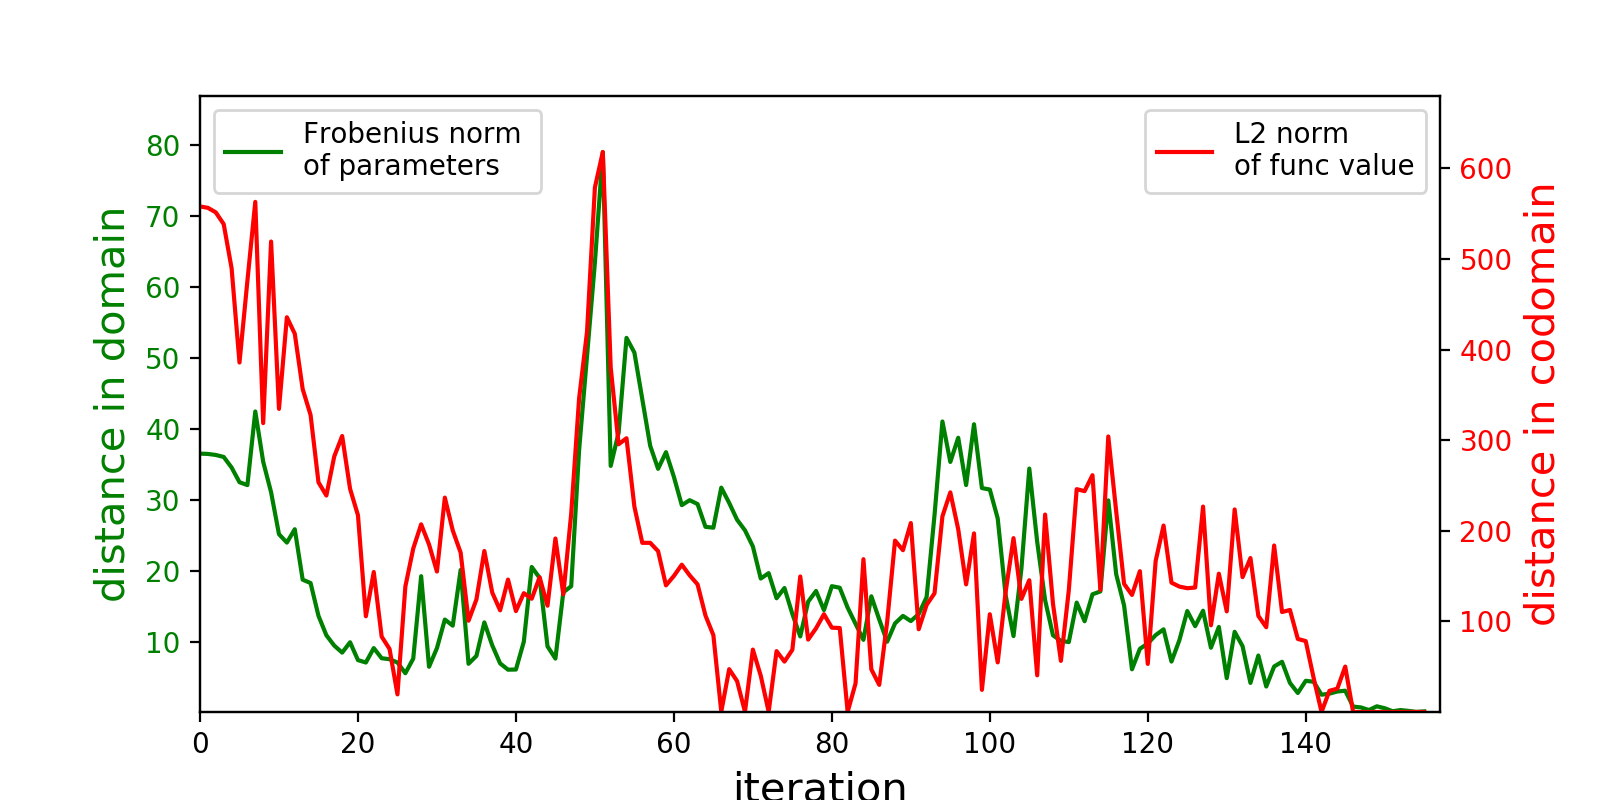

In [25]:
ex2.plot_distance()

<IPython.core.display.Javascript object>


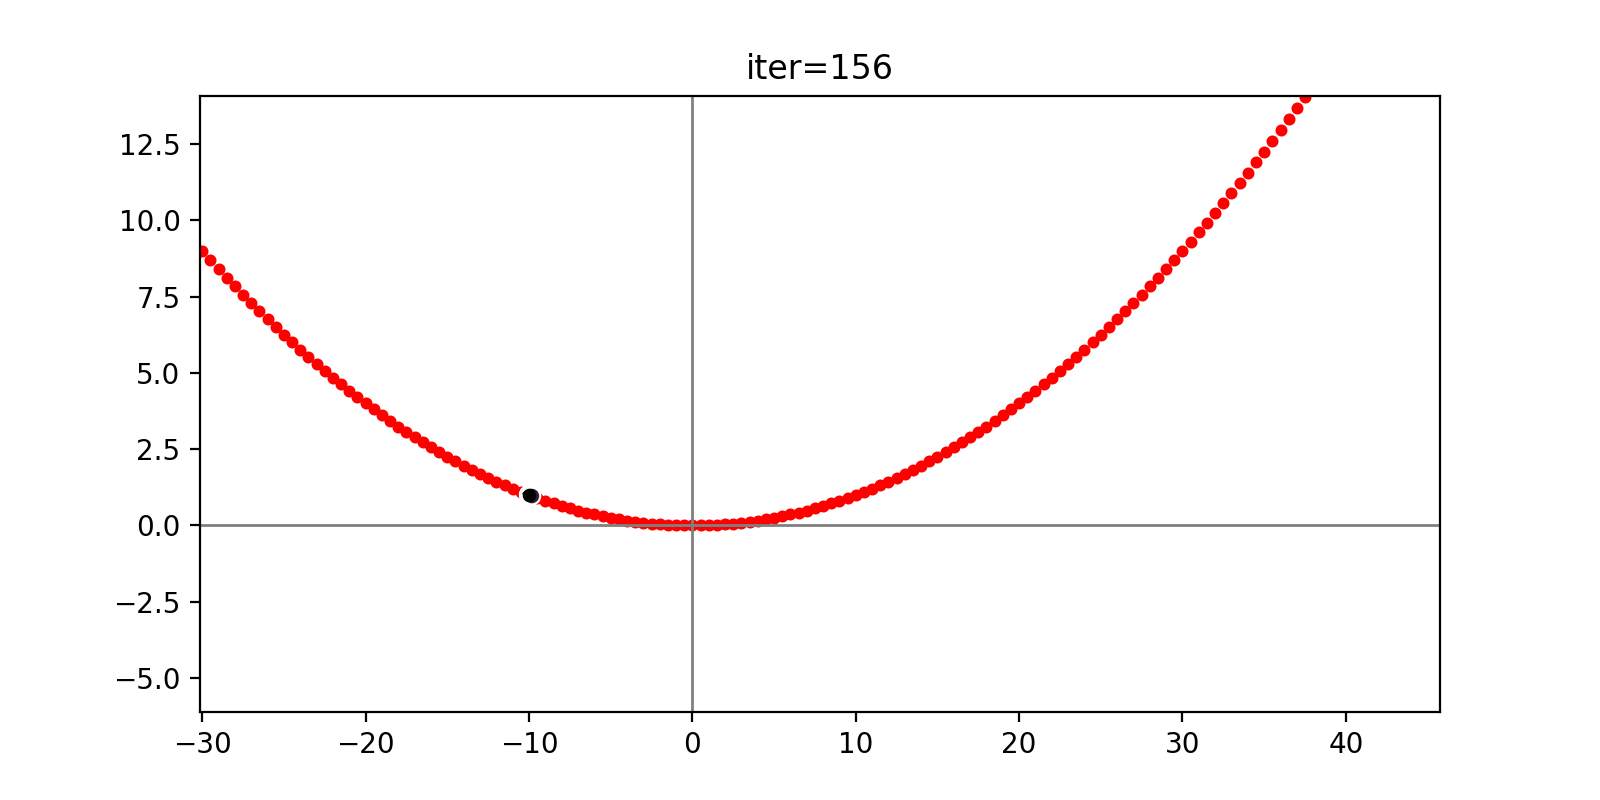

In [43]:
ex2.animate_moving_cluster()

<IPython.core.display.Javascript object>


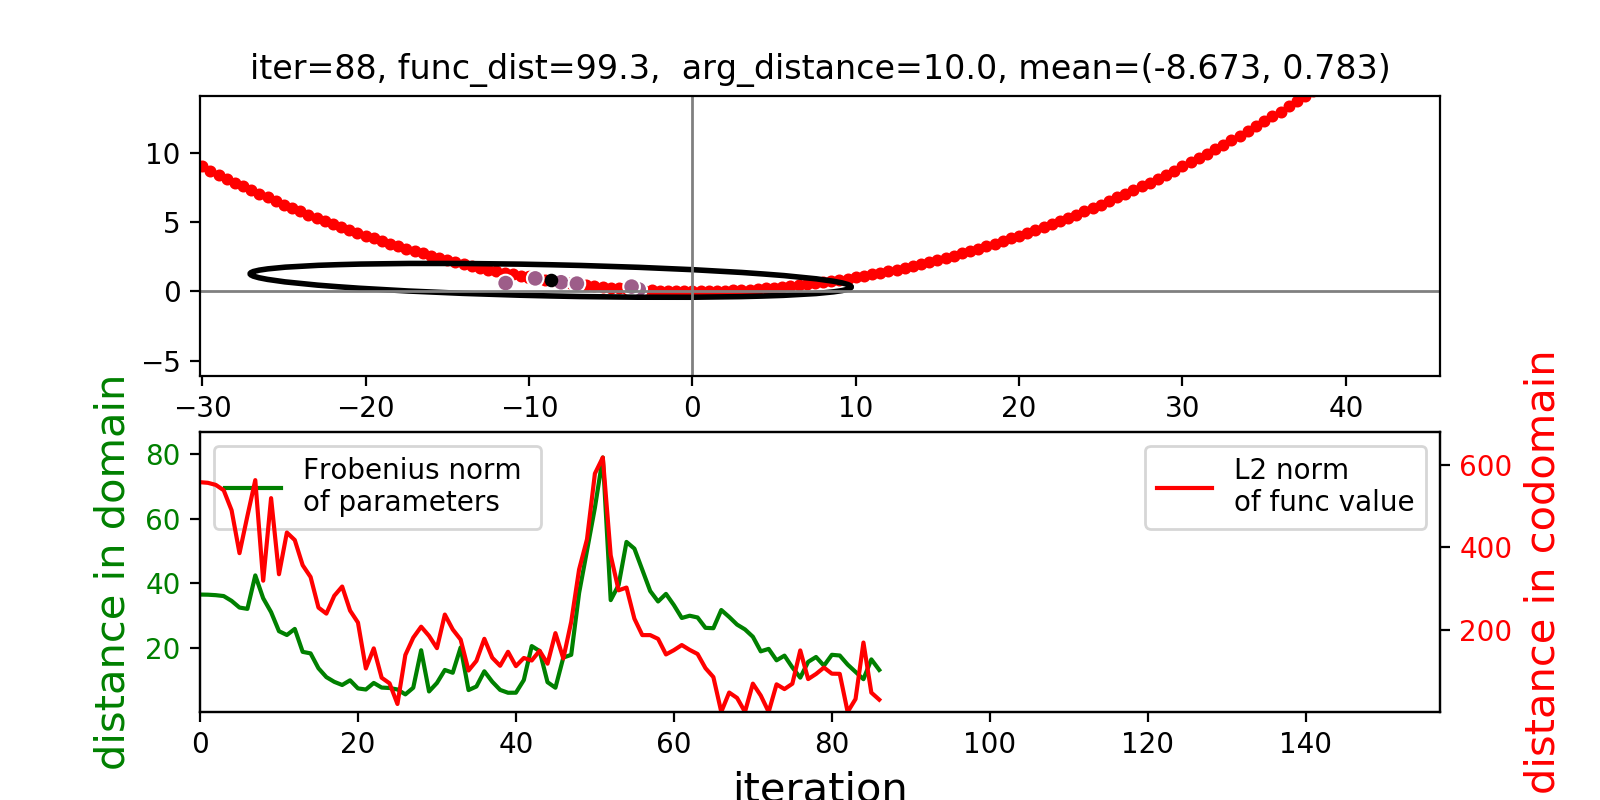

In [39]:
ex2.animate_scatterplot_distance()

## line search 1 step

In [40]:
mean0 = np.array([[-21.9],[10]])
sigma = np.ones((2,)) * 0.003
alpha = 0.00001
beta = 0.00002
np.random.seed(101)
optimal_trail = lambda x: 0.01 * x**2
x = np.linspace(-50, 50, 201)
y = optimal_trail(x)
trail = (x, y)

ex3 = non_convex_optimisation(bukin, d_bukin, np.array([-10,1]), 0, trail)
ex3.do_experiments(mean0, sigma, alpha, beta, line_search_1step, tolerance)

*******starting soon, intitial mean: ********
 [[-21.900]
 [10.000]]
stuck in local minimum!!
eigenvalue of variance = [0.000 0.000]
min = 0.44919540515500755, total iterations = 184, total evaluatios = 4973
 position = 0.5338033973358722 0.002849968225797939



In [ ]:
ex3.get_recorded_data()

<IPython.core.display.Javascript object>


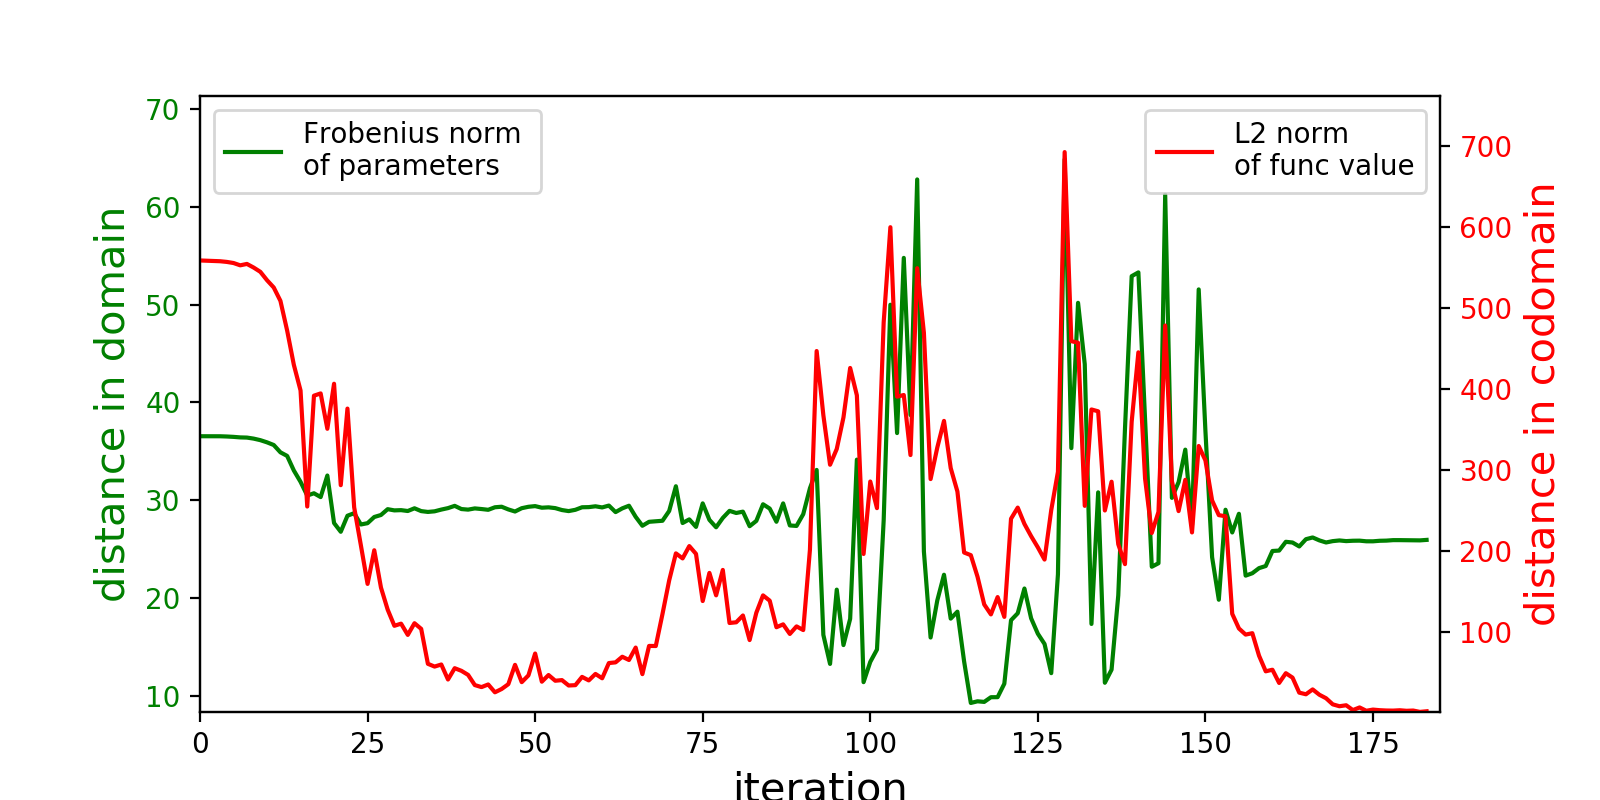

In [41]:
ex3.plot_distance()

<IPython.core.display.Javascript object>


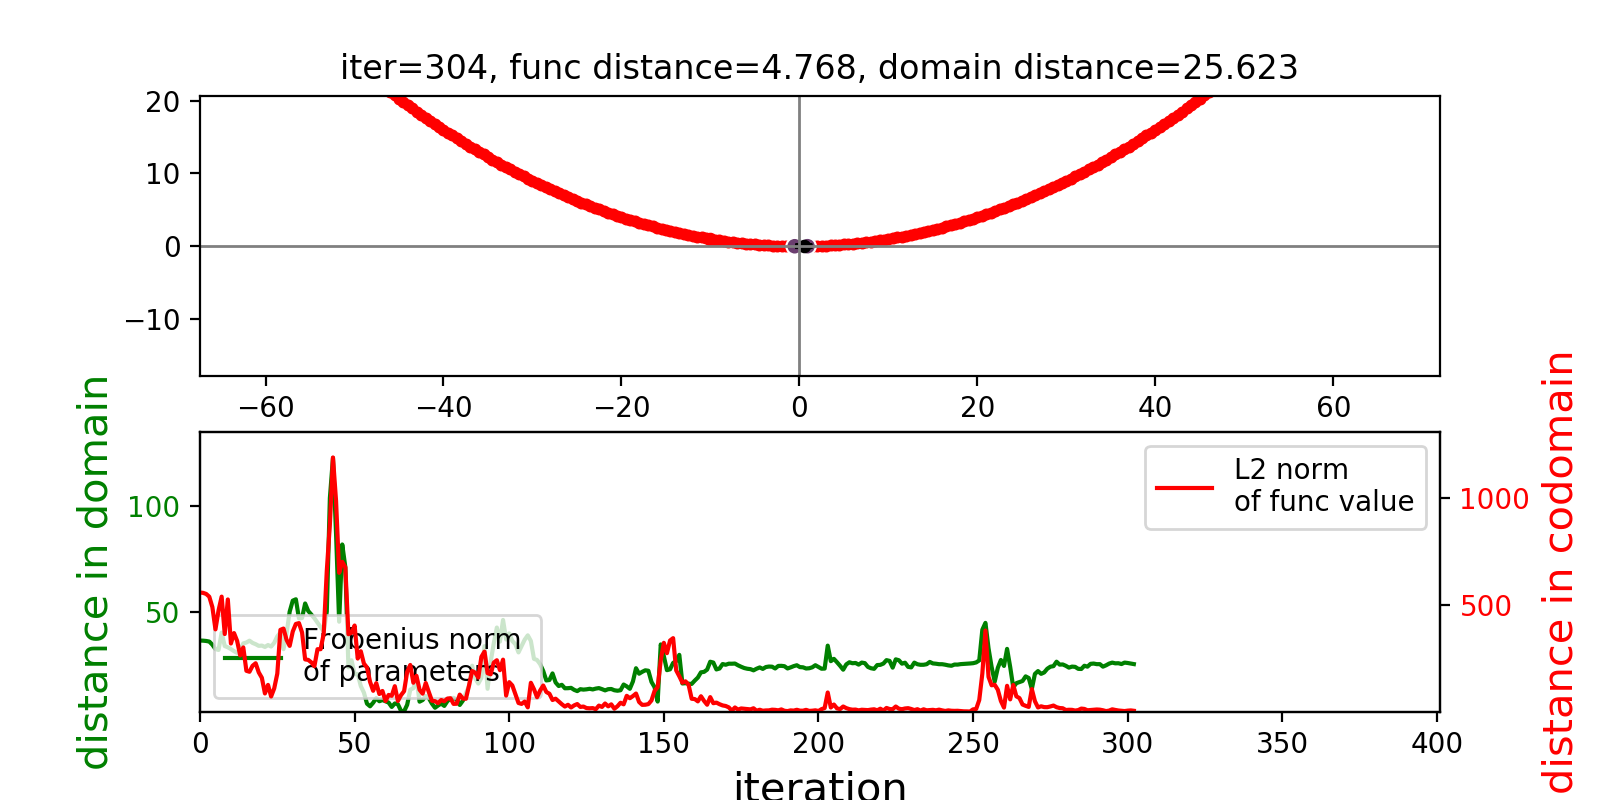

In [120]:
ex3.animate_scatterplot_distance()

## points cloud 

### sample some points from a square areas,  used as initial mean later

In [8]:
def sample_from_square(edge, center, num):
    rx = (np.random.rand(num) - 0.5) * 2 * edge[0] - center[0] / 2
    ry = (np.random.rand(num) - 0.5) * 2 * edge[1] - center[1] / 2
    return np.array([rx, ry]).reshape(num, 2)

In [9]:
np.random.seed(19)
points = sample_from_square(np.array([100,100]),  np.array([0, 0]), 50)

In [ ]:
mean0 = np.array([[-21.9],[10]])
sigma = np.ones((2,)) * 0.003
alpha = 0.00001
beta = 0.00002
tolerance = 1 * 1e-6
np.random.seed(101)
optimal_trail = lambda x: 0.01 * x**2
x = np.linspace(-50, 50, 201)
y = optimal_trail(x)
trail = (x, y)


ex4 = non_convex_optimisation(bukin, d_bukin, np.array([-10,1]), 0, ridge)
ex4.generate_point_cloud(sigma, alpha, beta, line_search, points)

<IPython.core.display.Javascript object>


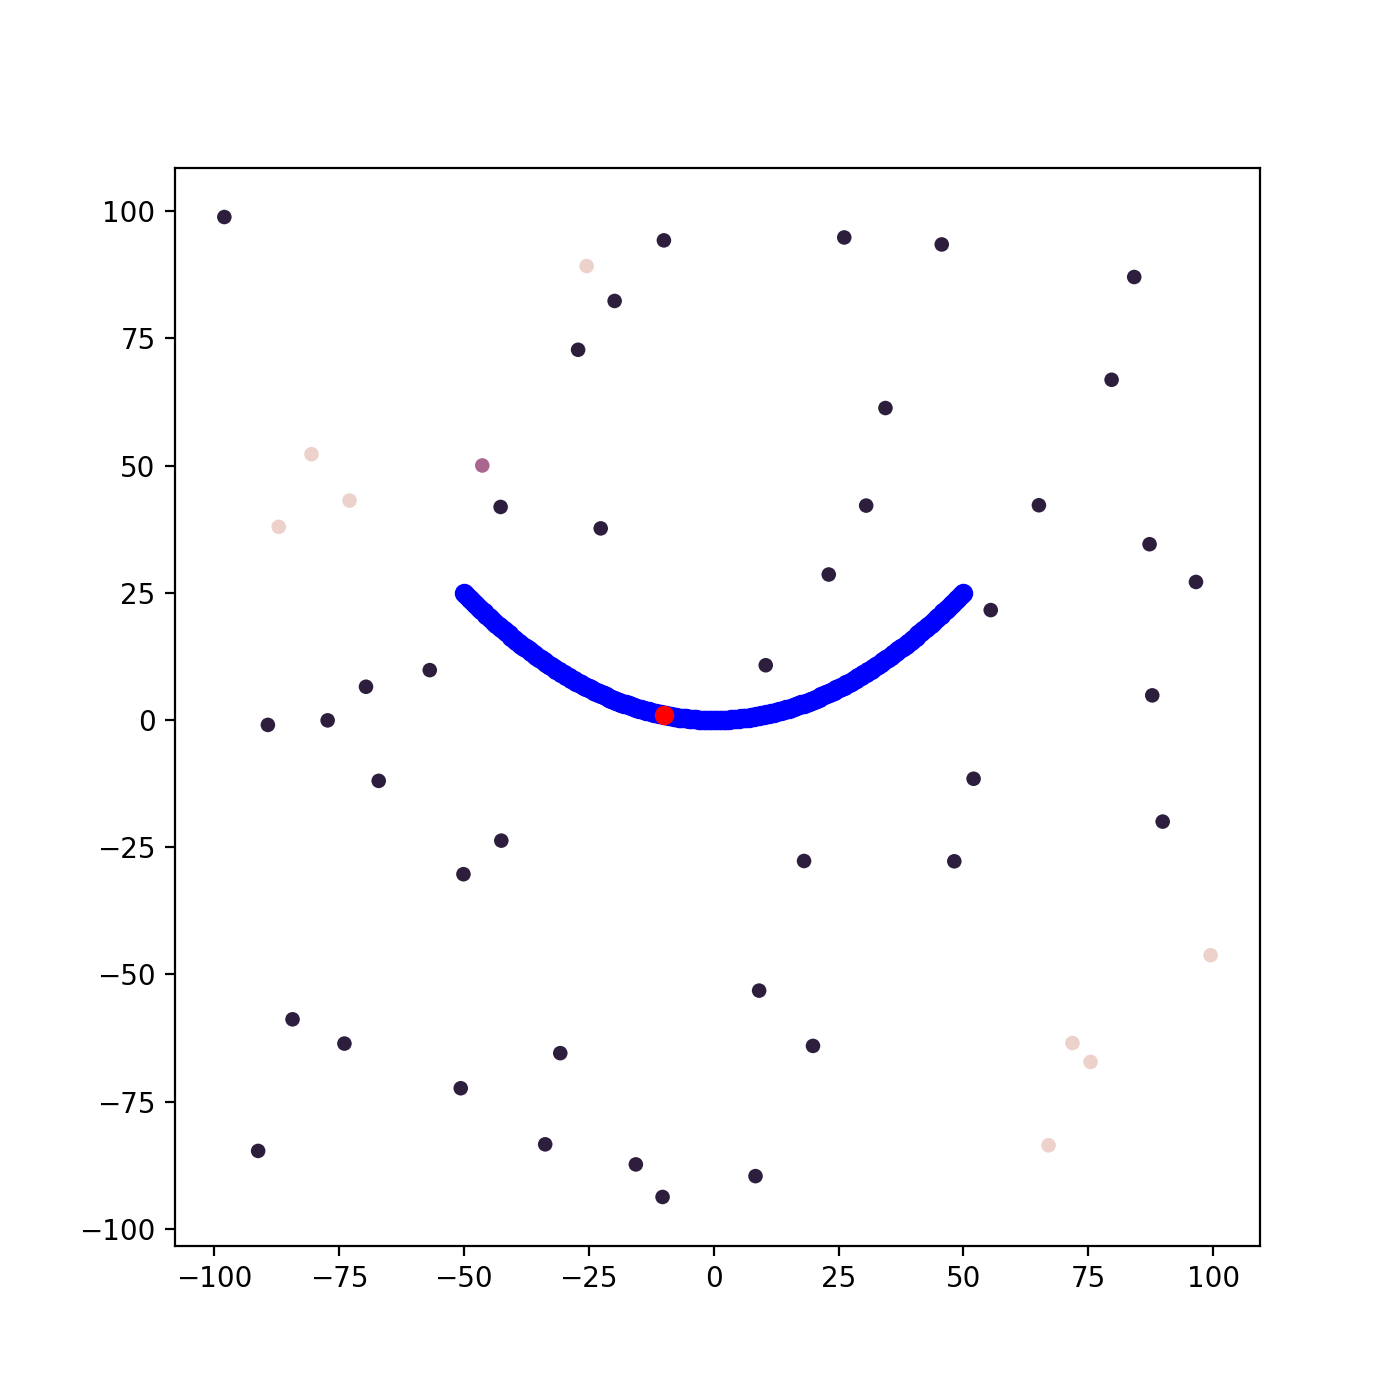

In [15]:
ex2.plot_cloud_point()
plt.scatter(ridge[0], ridge[1], c = 'blue')
plt.scatter(-10, 1, c = 'red')

In [16]:
res, points = ex2.get_results_points()
print("prob of global convergence", np.sum(res == 0) / res.shape[0])

prob of global convergence 0.6666666666666666


In [14]:
mean0 = np.array([[-21.9],[10]])
sigma = np.ones((2,)) * 0.003
alpha = 0.00001
beta = 0.00002
tolerance = 1 * 1e-6
np.random.seed(101)
optimal_trail = lambda x: 0.01 * x**2
x = np.linspace(-50, 50, 201)
y = optimal_trail(x)
trail = (x, y)


ex4 = non_convex_optimisation(bukin, d_bukin, np.array([-10,1]), 0, ridge)
ex4.generate_point_cloud(sigma, alpha, beta, do_nothing, points)

*******starting soon, intitial mean: ********
 [[-63.946]
 [-96.105]]
stuck in local minimum!!
eigenvalue of variance = [0.000 0.000]
min = 0.13542778736959574, total iterations = 400, total evaluatios = 538989
 position = -2.4209122079953658 0.05860815918820997

*******starting soon, intitial mean: ********
 [[-7.356]
 [44.987]]
Global minimum
eigenvalue of variance = [0.000 0.000]
min = 4.6254066807804863e-07, total iterations = 326, total evaluatios = 437554
 position = -9.999953745933192 0.9999907492080329

*******starting soon, intitial mean: ********
 [[-15.959]
 [-2.915]]
Global minimum
eigenvalue of variance = [0.000 0.000]
min = 7.824766413655482e-07, total iterations = 312, total evaluatios = 430730
 position = -10.000052174882464 1.0000104350037151



<IPython.core.display.Javascript object>


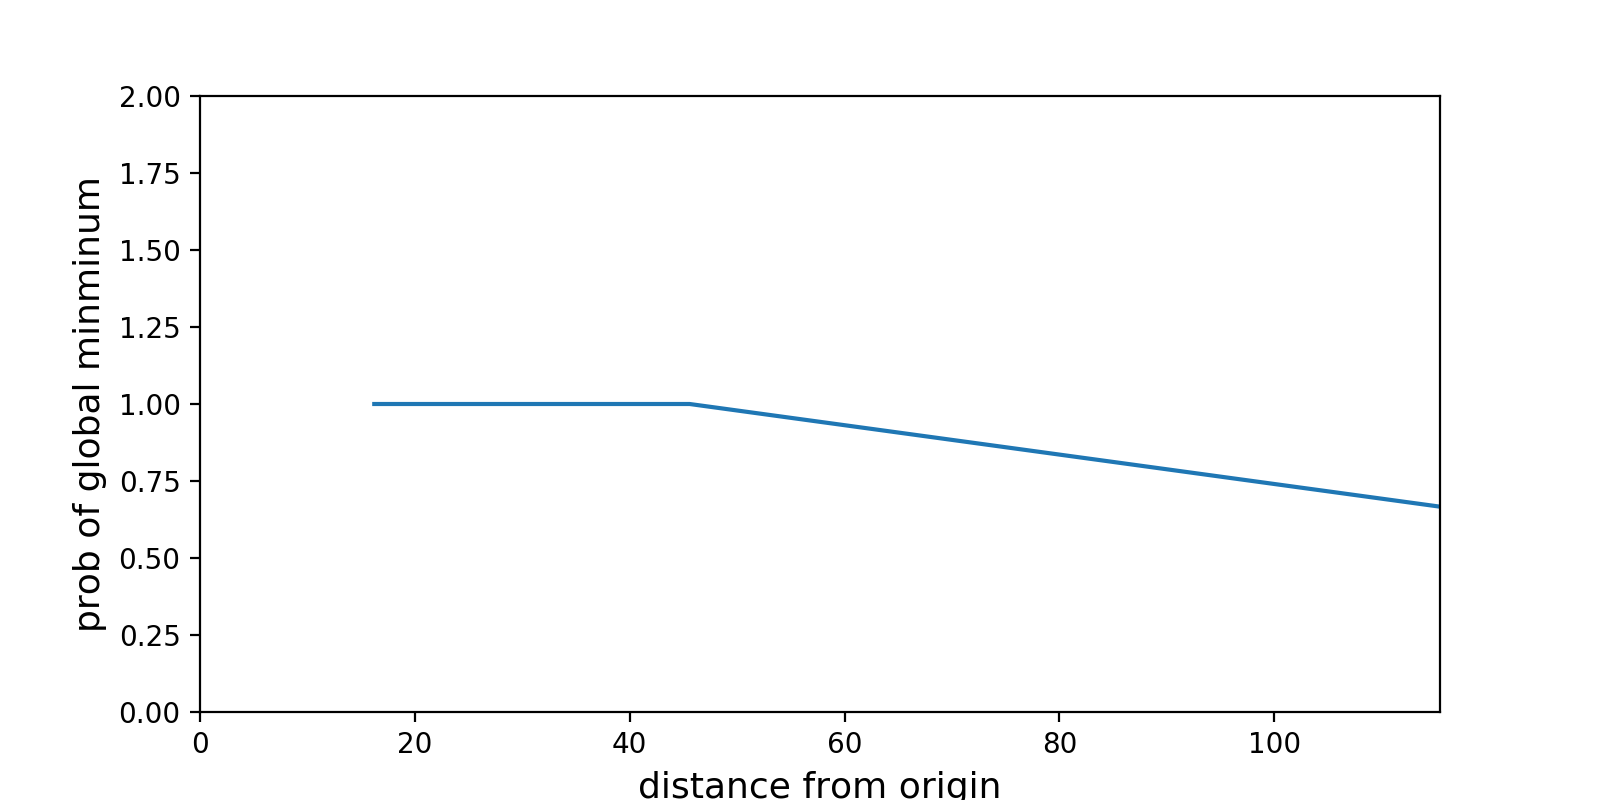

In [15]:
ex2.plot_prob_vs_radius()